In [1]:
import pandas as pd
import math
from random import sample 
import numpy as np
from datetime import datetime
import random

import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
sys.path.append('./models/')

import ease_user_imitation
import pretty_plotter
import main_metrics
import top_n_recommender

## Datasets EDA 

### 1. InstaCart Data 

In [3]:
order_products_train_df = pd.read_csv("../data/instacart/order_products__train.csv")[
    ['order_id', 'product_id']].rename({'product_id': 'good_foreign_id'}, axis = 1)

In [4]:
orders = pd.read_csv('../data/instacart/orders.csv')[['order_id', 'user_id']].rename(
    {'user_id': 'customer_id'}, axis = 1)

In [5]:
orders_and_users_dataset = orders.merge(order_products_train_df)

assert order_products_train_df.shape[0] == orders_and_users_dataset.shape[0]

<Axes: >

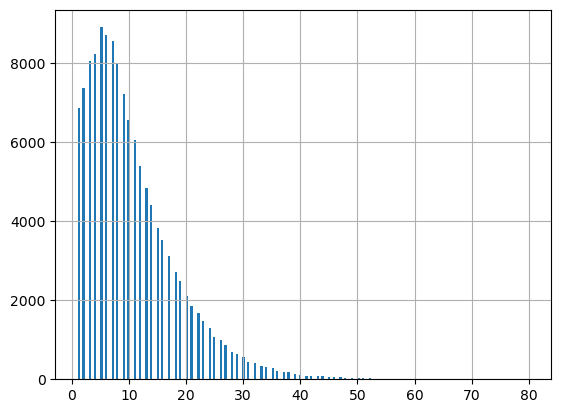

In [6]:
orders_and_users_dataset.groupby(['order_id']).good_foreign_id.agg(list).apply(lambda x: len(x)).hist(bins = 200)
#left-sided distribution - most of the baskets represented in the datasets contain less then 10-15 items in them

In [7]:
orders_and_users_dataset.groupby(['customer_id']).order_id.agg(list).apply(lambda x: len(x)).mean()
#avg. amount of orders per user

10.552759338155157

In [8]:
def return_indexes_to_drop(df): 
    baskets_dataset = df.groupby(['order_id']).agg(list)
    baskets_dataset['baskets_size'] = baskets_dataset.good_foreign_id.apply(lambda x: len(x))
    
    drop_indexes = baskets_dataset[baskets_dataset.baskets_size == 1].index.to_list()
    
    return drop_indexes

In [9]:
single_items_baskets = return_indexes_to_drop(orders_and_users_dataset)

In [10]:
instacart = orders_and_users_dataset[~orders_and_users_dataset.index.isin(single_items_baskets)]
instacart.shape

(1381791, 3)

In [11]:
#as there is no time data - we re splitting the datasets quaterly - 3/4 - train, 1/4 - test 
train_data = instacart[:1038462]
test_data =  instacart[~instacart.index.isin(train_data.index)]

In [12]:
def mask_values(lst, num):
    curr_lst = lst.copy()  
    new_list = sample(curr_lst, len(curr_lst) - num)
    return new_list


def create_masked_sample(df): 
    
    grouped_items = pd.DataFrame(df.groupby(['order_id']).agg(list)).reset_index()
    grouped_items['lists_len'] = grouped_items.good_foreign_id.apply(lambda x: len(x))
    grouped_items['num_to_mask'] = grouped_items['lists_len'].apply(lambda x: math.ceil(x * 0.2))
    grouped_items['lists_to_pred'] = grouped_items.apply(lambda row: mask_values(row['good_foreign_id'], 
                                                                                 row['num_to_mask']), axis=1)
    grouped_items = grouped_items[['order_id', 'customer_id', 'good_foreign_id', 'lists_len', 'num_to_mask',
           'lists_to_pred']].explode('lists_to_pred')

    masked_data = grouped_items[['order_id','lists_to_pred', 'customer_id']
                               ].rename({'lists_to_pred': 'good_foreign_id'}, axis = 1)
    
    return masked_data, grouped_items

masked_data, test_data_with_masked_stats = create_masked_sample(test_data)
#we gonna use masked_data for test and them joined stats from test_data_with_masked_stats for validation

In [13]:
test_data_with_masked_stats.customer_id = test_data_with_masked_stats.customer_id.apply(lambda x: x[0])

In [14]:
ts = test_data_with_masked_stats.drop_duplicates(['order_id', 'customer_id'])[
    ['order_id', 'customer_id', 'num_to_mask', 'good_foreign_id']].rename(
    {'good_foreign_id': 'full_basket'}, axis = 1)
ts = ts[ts.num_to_mask > 1].sample(5000)

In [15]:
def generate_masked_baskets(row):
    basket = row['full_basket']
    num_to_mask = row['num_to_mask']
    
    masked_baskets = []
    for num_items_to_mask in range(1, num_to_mask + 1):
        masked_indices = random.sample(range(len(basket)), num_items_to_mask)
        
        masked_basket = [item for idx, item in enumerate(basket) if idx not in masked_indices]
        masked_baskets.append(masked_basket)
    
    # adding actual_masked_num to indicate how many items were masked
    masked_baskets_with_info = []
    for i, masked_basket in enumerate(masked_baskets):
        masked_baskets_with_info.append({
            'masked_basket': masked_basket,
            'actual_masked_num': i + 1 
        })
    
    return masked_baskets_with_info


ts['masked_basket_info'] = ts.apply(lambda row: generate_masked_baskets(row), axis=1)
ts = ts.explode('masked_basket_info').reset_index(drop=True)

# extracting 'masked_basket' and 'actual_masked_num' from 'masked_basket_info' column
ts['masked_basket'] = ts['masked_basket_info'].apply(lambda x: x['masked_basket'])
ts['actual_masked_num'] = ts['masked_basket_info'].apply(lambda x: x['actual_masked_num'])
ts = ts.drop(columns=['masked_basket_info'])

In [16]:
ts.head()

,order_id,customer_id,num_to_mask,full_basket,masked_basket,actual_masked_num
0,573726,203407,2,"[24852, 30489, 20119, 26620, 20842, 4656, 1720...","[24852, 30489, 20119, 26620, 20842, 4656, 17200]",1
1,573726,203407,2,"[24852, 30489, 20119, 26620, 20842, 4656, 1720...","[24852, 30489, 20119, 26620, 4656, 7503]",2
2,2170169,157725,4,"[24852, 47209, 21903, 47626, 14452, 10246, 303...","[24852, 47209, 47626, 14452, 10246, 30391, 190...",1
3,2170169,157725,4,"[24852, 47209, 21903, 47626, 14452, 10246, 303...","[24852, 47209, 47626, 14452, 10246, 30391, 190...",2
4,2170169,157725,4,"[24852, 47209, 21903, 47626, 14452, 10246, 303...","[24852, 21903, 47626, 14452, 10246, 19057, 289...",3


In [18]:
pred_dataset_instacart = ease_user_imitation.recommend_items(train_data, ts, 'order_id', 'good_foreign_id')

Creating index mappings...
Index mappings created.
Creating sparse matrix...
Sparse matrix created.
Fitting EASE...
EASE fitted.
Generating user vectors...
User vectors generated.
Generating recommendations...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15956/15956 [00:17<00:00, 901.99it/s]


Recommendations generated.


In [19]:
pred_dataset_instacart.head(3)

,order_id,customer_id,num_to_mask,full_basket,masked_basket,actual_masked_num,vector,recs,preds
0,573726,203407,2,"[24852, 30489, 20119, 26620, 20842, 4656, 1720...","[24852, 30489, 20119, 26620, 20842, 4656, 17200]",1,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[390, 42, 670, 289, 969, 515, 2176, 109, 322,...","[4605, 21137, 46802, 8518, 20842, 35221, 26620..."
1,573726,203407,2,"[24852, 30489, 20119, 26620, 20842, 4656, 1720...","[24852, 30489, 20119, 26620, 4656, 7503]",2,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[289, 969, 109, 739, 515, 670, 322, 74, 226, ...","[8518, 20842, 44632, 33000, 35221, 46802, 3655..."
2,2170169,157725,4,"[24852, 47209, 21903, 47626, 14452, 10246, 303...","[24852, 47209, 47626, 14452, 10246, 30391, 190...",1,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[93, 150, 53, 108, 1, 37, 39, 139, 557, 130, ...","[13176, 47766, 30391, 39877, 24852, 26209, 289..."


In [20]:
# set(pred_dataset_instacart.loc[0].masked_basket) - set(pred_dataset_instacart.loc[1].masked_basket)

In [21]:
evaluation_df = pred_dataset_instacart.rename({'full_basket': 'original_basket'}, axis = 1)
# evaluation_df.customer_id = evaluation_df.customer_id.apply(lambda x: x[0])
evaluation_df = evaluation_df.drop_duplicates(subset = ['order_id', 'customer_id'])

In [22]:
classic_prec_rec_metrics = evaluation_df.copy()

classic_prec_rec_for_top_n_metrics = evaluation_df.copy()[['order_id', 'original_basket', 'num_to_mask', 'customer_id',
       'masked_basket', 'vector', 'recs']]

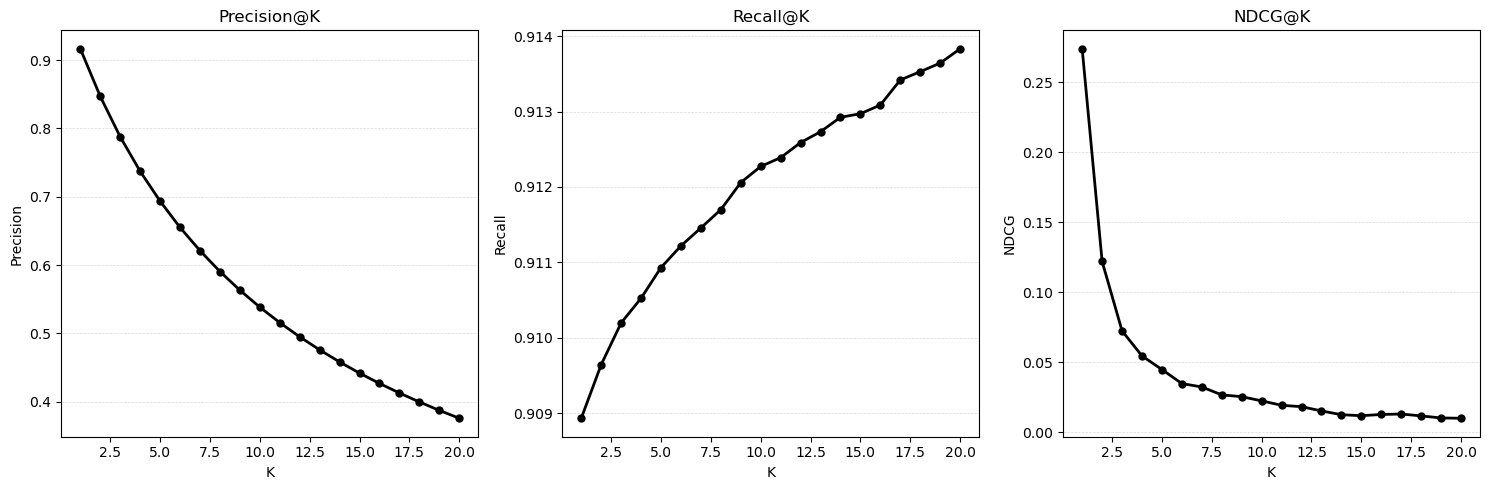

In [23]:
main_metrics.calculate_and_save_precision_recall(classic_prec_rec_metrics)
main_metrics.calculate_and_save_ndcg(classic_prec_rec_metrics)
pretty_plotter.plot_pretty_metrics(classic_prec_rec_metrics)

In [24]:
classic_prec_rec_metrics.describe().loc[:, classic_prec_rec_metrics.describe().columns.str.contains('@10')]

,precision@10,recall@10,ndcg@10
count,5000.000000,5000.000000,5000.000000
mean,0.538324,0.912273,0.022548
std,0.135613,0.044741,0.126927
min,0.333333,0.833333,0.000000
25%,0.411765,0.875000,0.000000
50%,0.526316,0.916667,0.000000
75%,0.640000,0.944444,0.000000
max,0.910448,1.000000,1.655740


### 2. Ta Feng Dataset

In [26]:
ta_feng_dataset = pd.read_csv('../data/ta_feng/ta_feng_all_months_merged.csv')[
    ['TRANSACTION_DT', 'CUSTOMER_ID', 'PRODUCT_ID']]

In [27]:
ta_feng_dataset.TRANSACTION_DT = ta_feng_dataset.TRANSACTION_DT .apply(lambda x: x.replace('/', '-'))

ta_feng_dataset.TRANSACTION_DT = [datetime.strptime(date, '%m-%d-%Y').strftime('%Y-%m-%d') for date in ta_feng_dataset.TRANSACTION_DT]

In [28]:
df = ta_feng_dataset.rename({'TRANSACTION_DT': 'date', 'CUSTOMER_ID': 'customer_id', 
                               'PRODUCT_ID': 'good_foreign_id'}, axis = 1)

In [29]:
df.shape

(817741, 3)

In [30]:
def return_indexes_to_drop(df): 
    baskets_dataset = df.groupby(['customer_id']).agg(list)
    baskets_dataset['baskets_size'] = baskets_dataset.good_foreign_id.apply(lambda x: len(x))
    
    drop_indexes = baskets_dataset[baskets_dataset.baskets_size == 1].index.to_list()
    
    return drop_indexes

In [31]:
single_items_baskets = return_indexes_to_drop(df)

te_feng = df[~df.index.isin(single_items_baskets)]
te_feng.shape

(817501, 3)

In [32]:
def labelling_order_id(df):
    
    #setting order id as its not impicitly mentioned in original data 
    #we count order id as label of basket of items for users puchases within a certain day

    grouped = df.groupby(['date', 'customer_id'])
    df['order_id'] = grouped.ngroup() + 1
    
    return df

labelling_order_id(te_feng).head(3)

,date,customer_id,good_foreign_id,order_id
0,2000-11-01,1104905,4710199010372,78
1,2000-11-01,418683,4710857472535,34
2,2000-11-01,1057331,4710043654103,75


<Axes: >

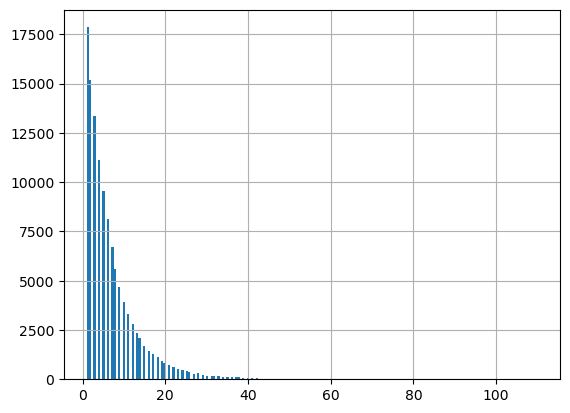

In [33]:
te_feng.groupby(['order_id']).good_foreign_id.agg(list).apply(lambda x: len(x)).hist(bins = 200)
#left-sided distribution - most of the baskets represented in the datasets contain less then 10 items

In [34]:
te_feng.groupby(['customer_id']).order_id.agg(list).apply(lambda x: len(x)).mean()
#avg. amount of orders per user

25.336298270625427

In [35]:
def split_train_test(group, time_threshold):
    
    train = group[group['date'] <= time_threshold]
    test = group[group['date'] > time_threshold]
    
    
    return train,test

In [36]:
time_threshold = '2000-11-06'

train_data, test_data = zip(*te_feng.groupby('order_id').apply(split_train_test, 
                                                                 time_threshold=time_threshold))

train_data = pd.concat(train_data)
test_data = pd.concat(test_data)

In [ ]:
masked_data, test_data_with_masked_stats = create_masked_sample(test_data)

In [49]:
ts = test_data_with_masked_stats.drop_duplicates(['order_id', 'customer_id'])[
    ['order_id', 'customer_id', 'num_to_mask', 'good_foreign_id']].rename(
    {'good_foreign_id': 'full_basket'}, axis = 1)

ts['masked_basket_info'] = ts.apply(lambda row: generate_masked_baskets(row), axis=1)
ts = ts.explode('masked_basket_info').reset_index(drop=True)

# extracting 'masked_basket' and 'actual_masked_num' from 'masked_basket_info' column
ts['masked_basket'] = ts['masked_basket_info'].apply(lambda x: x['masked_basket'])
ts['actual_masked_num'] = ts['masked_basket_info'].apply(lambda x: x['actual_masked_num'])
ts = ts.drop(columns=['masked_basket_info'])

In [51]:
pred_dataset_instacart = ease_user_imitation.recommend_items(train_data, ts, 'order_id', 'good_foreign_id')

Creating index mappings...
Index mappings created.
Creating sparse matrix...
Sparse matrix created.
Fitting EASE...
EASE fitted.
Generating user vectors...
User vectors generated.
Generating recommendations...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 82309/82309 [01:49<00:00, 748.58it/s]


Recommendations generated.


In [52]:
evaluation_df = pred_dataset_instacart.rename({'full_basket': 'original_basket'}, axis = 1)
# evaluation_df.customer_id = evaluation_df.customer_id.apply(lambda x: x[0])
evaluation_df = evaluation_df.drop_duplicates(subset = ['order_id', 'customer_id'])

classic_prec_rec_metrics = evaluation_df.copy()

classic_prec_rec_for_top_n_metrics = evaluation_df.copy()[['order_id', 'original_basket', 'num_to_mask', 'customer_id',
       'masked_basket', 'vector', 'recs']]

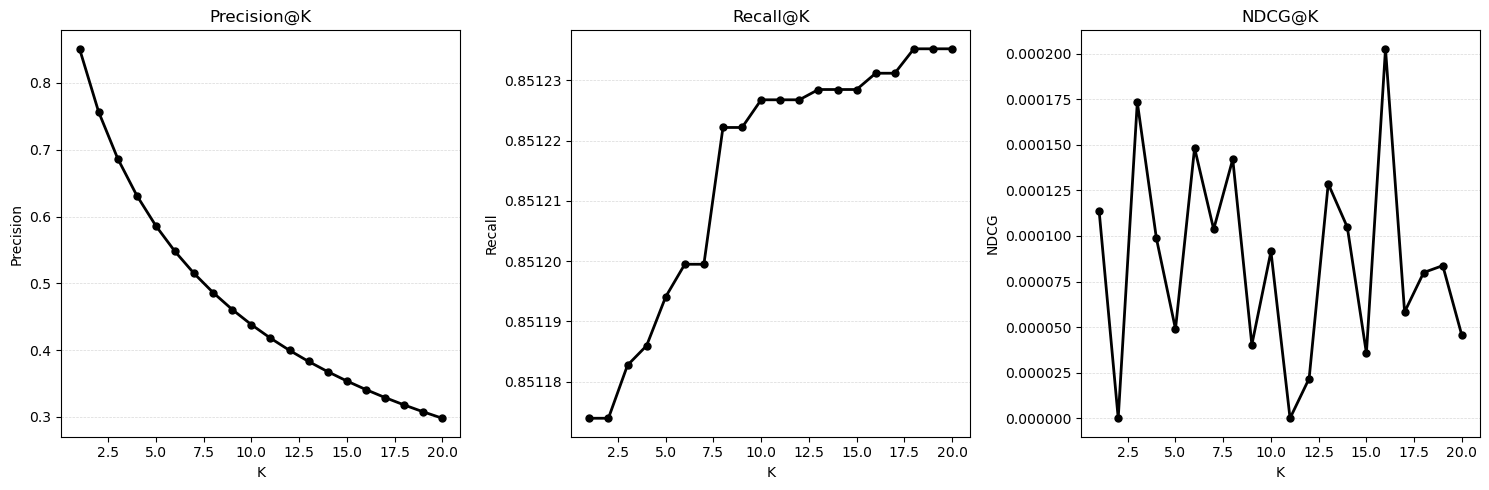

In [53]:
main_metrics.calculate_and_save_precision_recall(classic_prec_rec_metrics)
main_metrics.calculate_and_save_ndcg(classic_prec_rec_metrics)
pretty_plotter.plot_pretty_metrics(classic_prec_rec_metrics)

In [54]:
classic_prec_rec_metrics.describe().loc[:, classic_prec_rec_metrics.describe().columns.str.contains('@10')]

,precision@10,recall@10,ndcg@10
count,30820.000000,30820.000000,32547.000000
mean,0.438082,0.851227,0.000091
std,0.180970,0.116897,0.009923
min,0.090909,0.500000,0.000000
25%,0.285714,0.800000,0.000000
50%,0.444444,0.888889,0.000000
75%,0.583333,0.933333,0.000000
max,0.887640,1.000000,1.342375


### 3. DunnHumby Retail Transaction Data

In [55]:
dh_dataset = pd.read_csv('../data/dunnhumby/transaction_data.csv')[['household_key', 'BASKET_ID', 'PRODUCT_ID']].rename({'household_key': 'customer_id',
                                                                                                               'BASKET_ID': 'order_id',
                                                                                                               'PRODUCT_ID': 'good_foreign_id'}
                                                                                                             , axis = 1)

In [56]:
print(dh_dataset.shape)
dh_dataset.head()

(2595732, 3)


,customer_id,order_id,good_foreign_id
0,2375,26984851472,1004906
1,2375,26984851472,1033142
2,2375,26984851472,1036325
3,2375,26984851472,1082185
4,2375,26984851472,8160430


<Axes: >

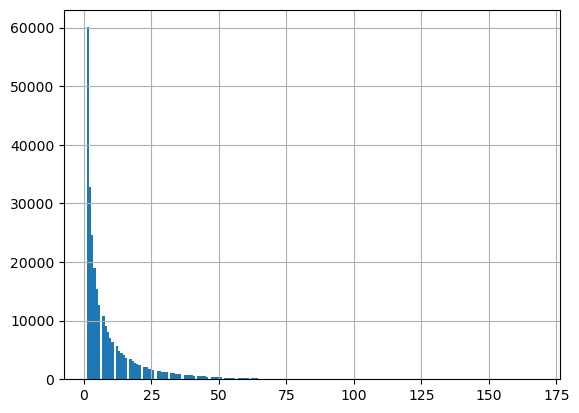

In [57]:
dh_dataset.groupby(['order_id']).good_foreign_id.agg(list).apply(lambda x: len(x)).hist(bins = 200)
#left-sided distribution - most of the baskets represented in the datasets contain less then 10-15 items in them

In [58]:
single_items_baskets = return_indexes_to_drop(dh_dataset)

In [59]:
retail = dh_dataset[~dh_dataset.index.isin(single_items_baskets)]
retail.shape

(2595732, 3)

In [60]:
#as there is no time data - we re splitting the datasets quaterly - 3/4 - train, 1/4 - test 
train_data = retail[:1946799]
test_data =  retail[~retail.index.isin(train_data.index)]

In [61]:
train_data.shape, test_data.shape

((1946799, 3), (648933, 3))

In [62]:
masked_data, test_data_with_masked_stats = create_masked_sample(test_data)
#we gonna use masked_data for test and them joined stats from test_data_with_masked_stats for validation

In [66]:
test_data_with_masked_stats.customer_id = test_data_with_masked_stats.customer_id.apply(lambda x: x[0])

In [67]:
ts = test_data_with_masked_stats.drop_duplicates(['order_id', 'customer_id'])[
    ['order_id', 'customer_id', 'num_to_mask', 'good_foreign_id']].rename(
    {'good_foreign_id': 'full_basket'}, axis = 1)

ts['masked_basket_info'] = ts.apply(lambda row: generate_masked_baskets(row), axis=1)
ts = ts.explode('masked_basket_info').reset_index(drop=True)

# extracting 'masked_basket' and 'actual_masked_num' from 'masked_basket_info' column
ts['masked_basket'] = ts['masked_basket_info'].apply(lambda x: x['masked_basket'])
ts['actual_masked_num'] = ts['masked_basket_info'].apply(lambda x: x['actual_masked_num'])
ts = ts.drop(columns=['masked_basket_info'])

ts.shape

(162286, 6)

In [70]:
ts = ts[ts.num_to_mask >= 2]

In [71]:
train_data = train_data.sample(50000)

In [72]:
pred_dataset_instacart = ease_user_imitation.recommend_items(train_data, ts, 'order_id', 'good_foreign_id')

Creating index mappings...
Index mappings created.
Creating sparse matrix...
Sparse matrix created.
Fitting EASE...
EASE fitted.
Generating user vectors...
User vectors generated.
Generating recommendations...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126834/126834 [06:27<00:00, 326.99it/s]


Recommendations generated.


In [73]:
evaluation_df = pred_dataset_instacart.rename({'full_basket': 'original_basket'}, axis = 1)
# evaluation_df.customer_id = evaluation_df.customer_id.apply(lambda x: x[0])
evaluation_df = evaluation_df.drop_duplicates(subset = ['order_id', 'customer_id'])

classic_prec_rec_metrics = evaluation_df.copy()

classic_prec_rec_for_top_n_metrics = evaluation_df.copy()[['order_id', 'original_basket', 'num_to_mask', 'customer_id',
       'masked_basket', 'vector', 'recs']]

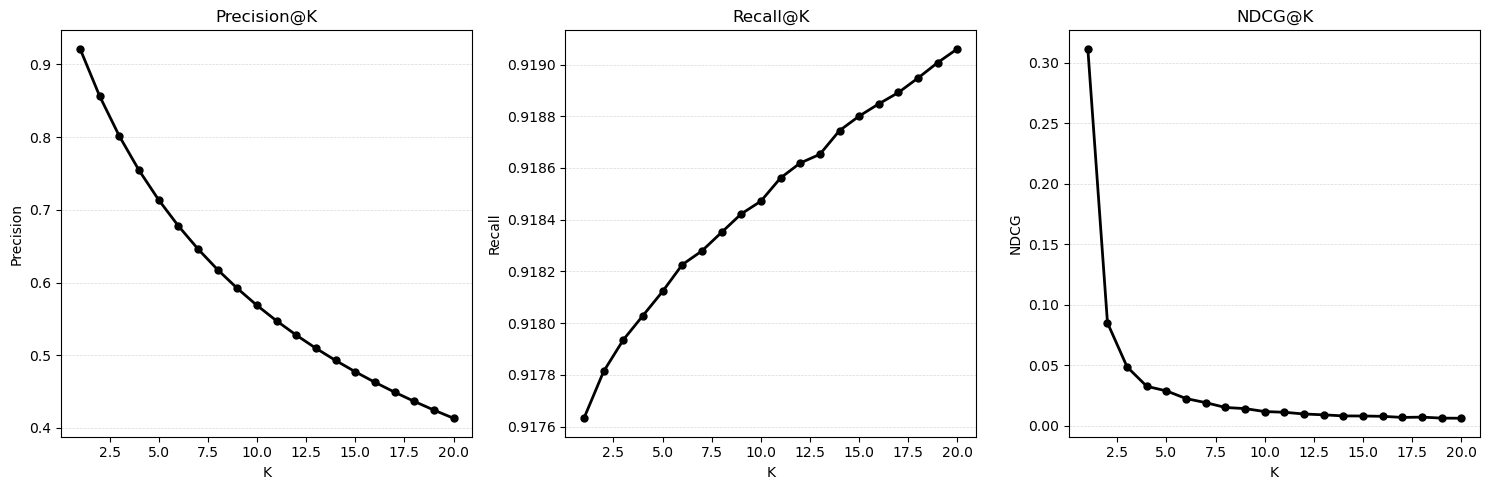

In [74]:
main_metrics.calculate_and_save_precision_recall(classic_prec_rec_metrics)
main_metrics.calculate_and_save_ndcg(classic_prec_rec_metrics)
pretty_plotter.plot_pretty_metrics(classic_prec_rec_metrics)

In [76]:
classic_prec_rec_metrics.describe().loc[:, classic_prec_rec_metrics.describe().columns.str.contains('@10')]

,precision@10,recall@10,ndcg@10
count,30899.000000,30899.000000,30899.000000
mean,0.568596,0.918472,0.011811
std,0.161140,0.046841,0.107764
min,0.333333,0.833333,0.000000
25%,0.428571,0.875000,0.000000
50%,0.550000,0.923077,0.000000
75%,0.696970,0.958333,0.000000
max,0.959596,1.000000,1.783508
